<a href="https://colab.research.google.com/github/i-SanMartin/FastAI/blob/main/06_Multicat/BearClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 8.1 MB/s 
     |████████████████████████████████| 188 kB 72.9 MB/s 
     |████████████████████████████████| 1.2 MB 58.5 MB/s 
     |████████████████████████████████| 46 kB 5.9 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 51 kB 420 kB/s 
Mounted at /content/gdrive


In [2]:
import shutil
from fastbook import *
from fastai.vision.widgets import *

In [3]:
!pip install -q jmd_imagescraper
from pathlib import Path
from jmd_imagescraper.core import *

In [4]:
pet_types = "grizzly bear", "black bear", "teddy bear"
path = Path().cwd()/"pets"

In [5]:
if path.exists():
    shutil.rmtree(path)

if not path.exists():
    path.mkdir()
    for o in pet_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = duckduckgo_search(path, o, o, max_results=100)

Duckduckgo search: grizzly bear


Duckduckgo search: black bear


Duckduckgo search: teddy bear


In [6]:
fns = get_image_files(path)
fns

(#300) [Path('/content/pets/black bear/059_511ffa62.jpg'),Path('/content/pets/black bear/045_790dea38.jpg'),Path('/content/pets/black bear/007_0c3f4a15.jpg'),Path('/content/pets/black bear/064_971c947c.jpg'),Path('/content/pets/black bear/019_6ff11154.jpg'),Path('/content/pets/black bear/014_79666aa3.jpg'),Path('/content/pets/black bear/029_24b98a72.jpg'),Path('/content/pets/black bear/047_99bf1b2e.jpg'),Path('/content/pets/black bear/024_d64ff906.jpg'),Path('/content/pets/black bear/026_44aa8f6d.jpg')...]

In [7]:
failed = verify_images(fns)
failed

(#0) []

##Single Label

In [39]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [40]:
pets = pets.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = pets.dataloaders(path)

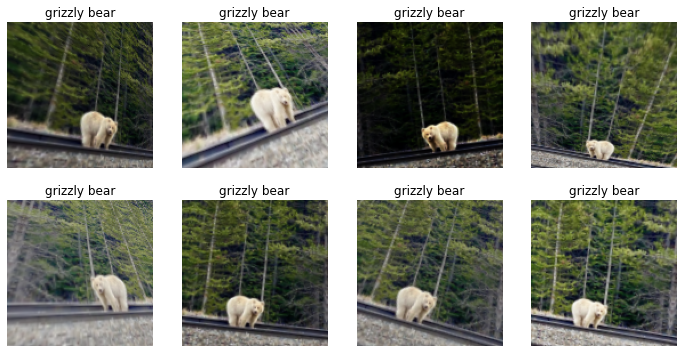

In [10]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [41]:
pets = pets.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pets.dataloaders(path)

In [42]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

In [43]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.623285,0.366632,0.166667,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.600631,0.270849,0.100000,00:02
1,0.476993,0.366091,0.133333,00:02
2,0.379234,0.371328,0.100000,00:02
3,0.303478,0.368013,0.100000,00:02


##MultiLabel

In [44]:
def get_y(r): 
  if parent_label(r) == "black bear":
    return ["black bear"]
  elif parent_label(r) == "grizzly bear":
    return ["grizzly bear"]
  elif parent_label(r) == "teddy bear":
    return ["teddy bear"]

In [45]:
print(get_y('/content/pets/black bear/001_3a2bb2f1.jpg'))

['black bear']


In [46]:
pets = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_y,
    item_tfms=Resize(128))

In [47]:
pets = pets.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pets.dataloaders(path)
dls.train_ds[0]

(PILImage mode=RGB size=474x474, TensorMultiCategory([0., 1., 0.]))

In [48]:
dls.train.vocab[0]

'black bear'

In [49]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.8))

In [50]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.987917,0.462805,0.822222,00:02


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.539645,0.345640,0.911111,00:02
1,0.430339,0.255527,0.944444,00:02
2,0.343554,0.249702,0.950000,00:02
3,0.294533,0.242525,0.955556,00:02


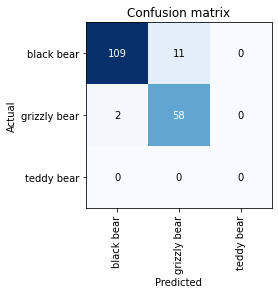

In [51]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

,target,predicted,probabilities,loss
0,black bear,grizzly bear,"TensorBase([0.0017, 1.0000, 0.0011])",6.090437889099121
1,black bear,black bear;grizzly bear,"TensorBase([9.9567e-01, 9.8291e-01, 1.9728e-04])",1.358029842376709
2,grizzly bear,black bear,"TensorBase([0.9146, 0.3240, 0.0259])",1.2044142484664917
3,black bear,black bear;grizzly bear,"TensorBase([0.7128, 0.9470, 0.0458])",1.1076576709747314
4,black bear,black bear;grizzly bear,"TensorBase([0.9340, 0.8161, 0.0082])",0.5898586511611938
5,teddy bear,grizzly bear;teddy bear,"TensorBase([0.0188, 0.7192, 0.9286])",0.45444008708000183
6,black bear,black bear;grizzly bear,"TensorBase([9.8723e-01, 6.2992e-01, 5.5044e-04])",0.3358154296875
7,grizzly bear,black bear;grizzly bear,"TensorBase([6.2997e-01, 9.9985e-01, 2.9237e-05])",0.3314518332481384


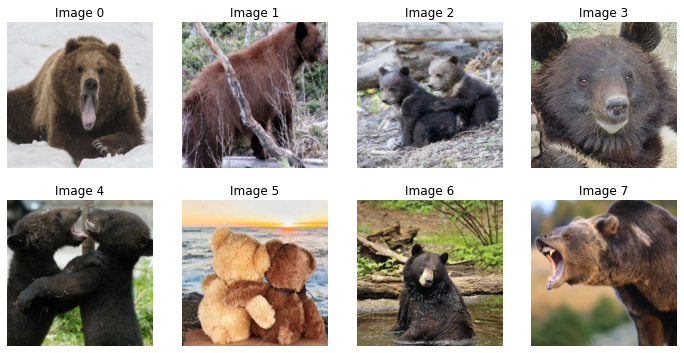

In [52]:
interp.plot_top_losses(8, nrows=2)

In [64]:
interp.most_confused()

[('black bear', 'grizzly bear', 11), ('grizzly bear', 'black bear', 2)]

In [66]:
preds,targs = learn.get_preds()

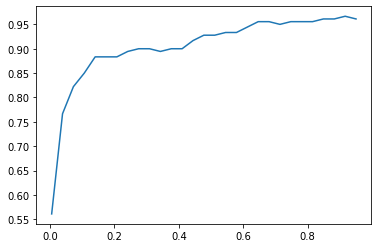

In [69]:
xs = torch.linspace(0.005,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);